**Students**
 
 Shubham Deshmukh (Roll no = 650) 

 Anirudha Thorat (Roll no = 653)

 Priyanshu Tripathi (Roll no = 656 )

 Gaurav Gupta (Roll no = 654 )


 
Subject : Deep learning

CNN for self driving car



DATASET: 



https://drive.google.com/drive/folders/1pgdGarzTCp5KB3gUprohWTwHNNLEt2ad?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
fileLoc = "/gdrive/MyDrive/self driving car dataset/archive.zip"

In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/self driving car dataset/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
import os
print(os.listdir("/tmp/data/IMG"))

['right_2016_12_01_13_42_53_423.jpg', 'center_2016_12_01_13_35_58_455.jpg', 'center_2016_12_01_13_42_15_716.jpg', 'right_2016_12_01_13_42_12_471.jpg', 'right_2016_12_01_13_40_45_876.jpg', 'right_2016_12_01_13_35_42_545.jpg', 'left_2016_12_01_13_34_55_671.jpg', 'left_2016_12_01_13_44_44_053.jpg', 'center_2016_12_01_13_34_28_097.jpg', 'right_2016_12_01_13_43_17_443.jpg', 'center_2016_12_01_13_41_05_458.jpg', 'center_2016_12_01_13_45_56_990.jpg', 'center_2016_12_01_13_45_48_172.jpg', 'center_2016_12_01_13_46_29_499.jpg', 'left_2016_12_01_13_42_05_970.jpg', 'right_2016_12_01_13_42_32_650.jpg', 'left_2016_12_01_13_43_58_154.jpg', 'right_2016_12_01_13_43_59_687.jpg', 'center_2016_12_01_13_42_26_172.jpg', 'right_2016_12_01_13_46_16_968.jpg', 'center_2016_12_01_13_42_11_658.jpg', 'right_2016_12_01_13_32_42_446.jpg', 'left_2016_12_01_13_46_04_887.jpg', 'left_2016_12_01_13_44_34_441.jpg', 'left_2016_12_01_13_44_59_420.jpg', 'center_2016_12_01_13_33_16_252.jpg', 'left_2016_12_01_13_46_01_745.jpg'

In [5]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

from keras import layers

from keras import models

from keras.layers import (Input, Dense, Activation, ZeroPadding2D,
BatchNormalization, Flatten, Conv2D, concatenate, Lambda)

from keras.layers import (AveragePooling2D, MaxPooling2D, Dropout,
GlobalMaxPooling2D, GlobalAveragePooling2D)

from keras.models import Model, load_model
from keras import regularizers, optimizers

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

# print(os.listdir("../input"))
print(os.listdir('/tmp/data'))

['IMG', 'driving_log.csv']


In [6]:
path = '/tmp/data'
path = os.path.join(path,'driving_log.csv')

data_frame = pd.read_csv(path)
center = data_frame[data_frame.columns[0]].values
left = data_frame[data_frame.columns[1]].values
right = data_frame[data_frame.columns[2]].values
steering = data_frame[data_frame.columns[3]].values

no_of_examples = len(steering)
print(no_of_examples)

8036


Data augmentation

In [7]:
def random_flip(image, steering_angle):
    
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    
    return image, steering_angle

In [8]:
train_x = []
train_y = []

img_folder = '/tmp/data/IMG'
stear_adjust_factor = 0.2
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 100

for i in range(no_of_examples):
    
    for choice in range(3):
        
        if choice == 0: #Center
            img = cv2.imread(os.path.join(img_folder,center[i].split('IMG/')[1]))
            steering_angle = steering[i]

        elif choice == 1: #Left
            img = cv2.imread(os.path.join(img_folder,left[i].split('IMG/')[1]))
            steering_angle = steering[i] + stear_adjust_factor

        elif choice == 2: #Right
            img = cv2.imread(os.path.join(img_folder,right[i].split('IMG/')[1]))
            steering_angle = steering[i] - stear_adjust_factor
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
        img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
        
        train_x.append(img)
        train_y.append(steering_angle)
        
        flip_img,steering_angle = random_flip(img,steering_angle)
                
        train_x.append(flip_img)
        train_y.append(steering_angle)
        

train_x = np.array(train_x)
train_x = np.reshape(train_x,[train_x.shape[0],train_x.shape[1],train_x.shape[2],1])

train_y = np.array(train_y)
train_y = np.reshape(train_y,[train_y.shape[0],1])

print(train_x.shape)
print(train_y.shape)

(48216, 100, 100, 1)
(48216, 1)


In [9]:
x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,random_state=42,test_size=.20)

In [10]:
import tensorflow as tf
def model(height,width):
        
    x_input = Input(shape=(height,width,1))
    
    x = Conv2D(32,(3,3),activation='relu',padding='same')(x_input)
    
    x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    
    x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
    
    x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    
    x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    
    x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
       
    x = BatchNormalization()(x)
    x = Dense(512)(x)
    x = Dense(256)(x)
    x = Dense(64)(x)
    x = Dense(1)(x)
    
    model = Model(inputs=x_input,outputs=x,name='model')
    
    return model
    
model = model(IMAGE_HEIGHT,IMAGE_WIDTH)
print(model.summary())

opt = tf.optimizers.Adam(lr=0.0001)

model.compile(loss='mse',
             optimizer=opt,
             metrics=['mse'])

hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
1206/1206 [==============================] - 50s 34ms/step - loss: 0.2173 - mse: 0.2173 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 2/5
1206/1206 [==============================] - 40s 33ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 3/5
1206/1206 [==============================] - 40s 33ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 4/5
1206/1206 [==============================] - 40s 33ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/5
1206/1206 [==============================] - 40s 33ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0142 - val_mse: 0.0142


In [11]:
results = model.evaluate(x_test, y_test, batch_size= 32)
print("test loss", results)

302/302 [==============================] - 4s 12ms/step - loss: 0.0142 - mse: 0.0142
test loss [0.014158517122268677, 0.014158517122268677]


In [12]:
print(x_test[0])

[[[ 58]
  [ 99]
  [155]
  ...
  [ 99]
  [ 99]
  [ 99]]

 [[ 93]
  [134]
  [112]
  ...
  [ 98]
  [ 98]
  [ 98]]

 [[110]
  [ 67]
  [115]
  ...
  [ 98]
  [ 98]
  [ 98]]

 ...

 [[ 33]
  [ 35]
  [ 33]
  ...
  [ 56]
  [ 27]
  [ 25]]

 [[ 30]
  [ 26]
  [ 35]
  ...
  [ 37]
  [ 34]
  [ 34]]

 [[ 24]
  [ 33]
  [ 39]
  ...
  [ 40]
  [ 41]
  [ 43]]]


In [13]:
from google.colab import files
from google.colab.patches import cv2_imshow
uploaded = files.upload()

In [14]:
from IPython.display import clear_output 
import time

for i in range(5):
  img = cv2.imread(f'{i+1}.jpg')
  plt.imshow(img)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
  img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
  plt.show()

  pred_data = np.array([img])
  ans = model.predict(pred_data)

  angle = ans[0][0] * -180

  from PIL import Image
  import matplotlib.pyplot as plt

  im = Image.open("steering.png")
  im = im.rotate(angle) # Rotates counter clock-wise.
  implot = plt.imshow(im)
  plt.show()
  time.sleep(4)
  
  clear_output()

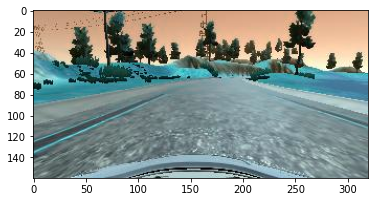

1/1 [==============================] - 0s 15ms/step


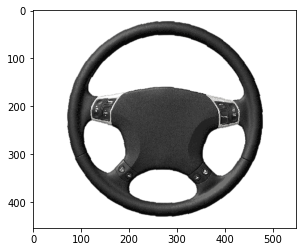

In [15]:
img = cv2.imread("1.jpg")
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
plt.show()

pred_data = np.array([img])
ans = model.predict(pred_data)

angle = ans[0][0] * -180

from PIL import Image
import matplotlib.pyplot as plt

im = Image.open("steering.png")
im = im.rotate(angle) # Rotates counter clock-wise.
implot = plt.imshow(im)
plt.show()

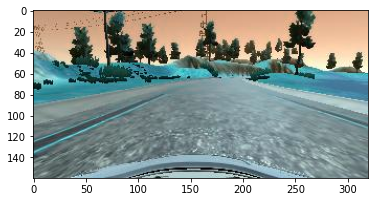

1/1 [==============================] - 0s 18ms/step
output :  0.009362496
Calibrated Angle :  -1.6852493584156036


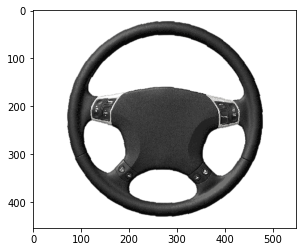

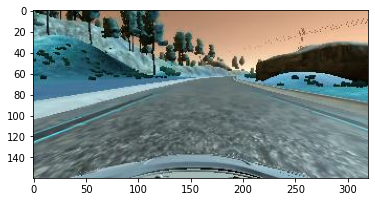

1/1 [==============================] - 0s 18ms/step
output :  -0.01500497
Calibrated Angle :  2.7008946239948273


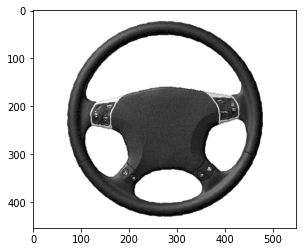

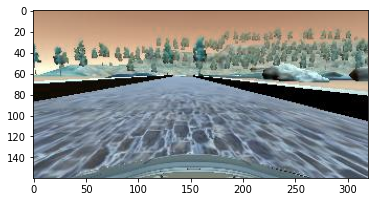

1/1 [==============================] - 0s 17ms/step
output :  -0.08860766
Calibrated Angle :  15.949379056692123


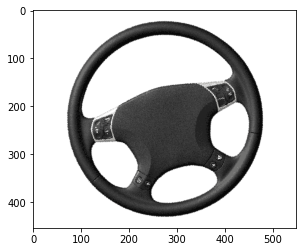

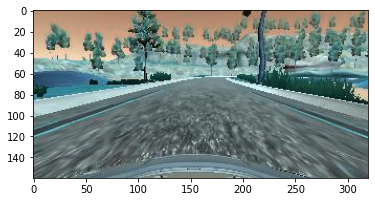

1/1 [==============================] - 0s 19ms/step
output :  -0.010184966
Calibrated Angle :  1.8332938849925995


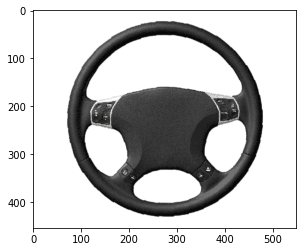

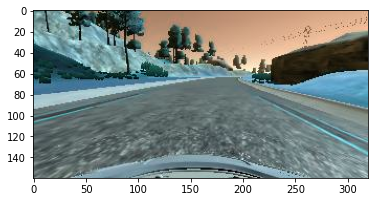

1/1 [==============================] - 0s 22ms/step
output :  0.0002870189
Calibrated Angle :  -0.05166340037249029


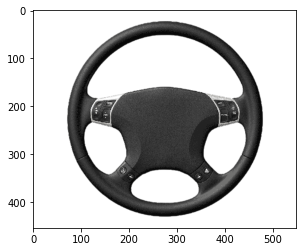

In [20]:
from IPython.display import clear_output 
import time

for i in range(5):
  img = cv2.imread(f'{i+1}.jpg')
  plt.imshow(img)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
  img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
  plt.show()

  pred_data = np.array([img])
  ans = model.predict(pred_data)
  print("output : ",ans[0][0])

  angle = ans[0][0] * -180

  from PIL import Image
  import matplotlib.pyplot as plt

  im = Image.open("steering.png")
  im = im.rotate(angle) # Rotates counter clock-wise.
  print("Calibrated Angle : ",angle)
  implot = plt.imshow(im)
  plt.show()
  time.sleep(4)
  
 

In [16]:
model.save('Saved_Model.h5')

## --  END --